In [30]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy as sp
import numpy as np

In [31]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'simulator',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


In [32]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20221020.feed_actions 
WHERE toDate(time) between '2022-10-03' and '2022-10-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [33]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


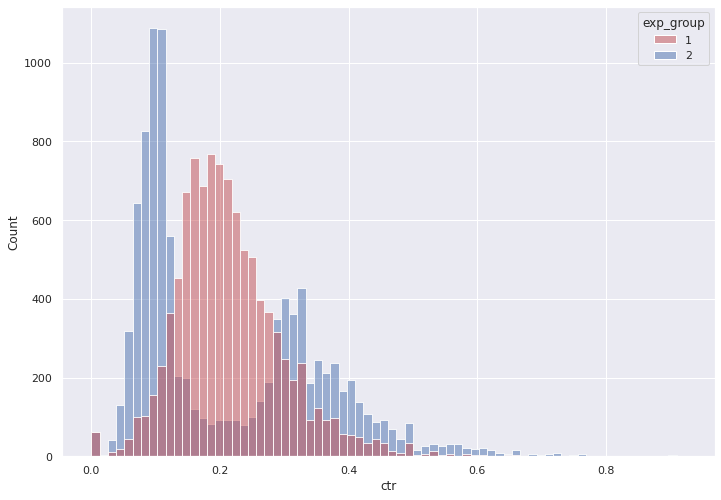

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [35]:
mean1=df[df.exp_group == 1].ctr.mean()
mean2=df[df.exp_group == 2].ctr.mean()
print('Среднее по группе 1:', mean1)
print('Среднее по группе 2:', mean2)

Среднее по группе 1: 0.21560459841296287
Среднее по группе 2: 0.21441927347479375


In [8]:
ttest_pval=sp.stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

if ttest_pval[1]>0.05:
    print('t-test pvalue: ',ttest_pval[1],', Гипотеза о присутствии отличий не принята')
else:
    print('t-test pvalue: ',ttest_pval[1],', Гипотеза о присутствии отличий принята')

t-test pvalue:  0.4780623130874935 , Гипотеза о присутствии отличий не принята


In [42]:
mw_pval=sp.stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

if mw_pval[1]>0.05:
    print('Mannwhitney pvalue: ',mw_pval[1],', Гипотеза о присутствии отличий не принята')
else:
    print('Mannwhitney pvalue: ',mw_pval[1],', Гипотеза о присутствии отличий принята')

Mannwhitney pvalue:  6.0376484617779035e-56 , Гипотеза о присутствии отличий принята


In [10]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

<AxesSubplot:xlabel='sm_ctr', ylabel='Count'>

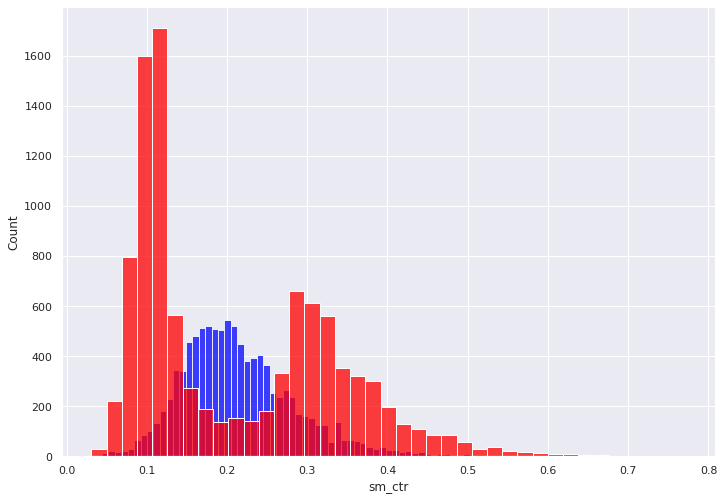

In [11]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group1['sm_ctr']=group1.apply(lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_1,5),axis=1)

group2 = df[df.exp_group == 2].copy()
group2['sm_ctr']=group2.apply(lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_2,5),axis=1)

sns.histplot(data=group1,x='sm_ctr',color='blue')
sns.histplot(data=group2,x='sm_ctr',color='red')

<AxesSubplot:xlabel='ctr', ylabel='Count'>

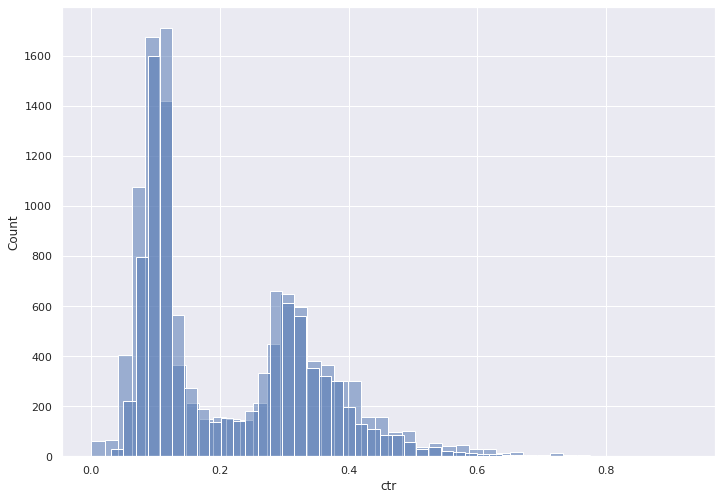

In [43]:
sns.histplot(data = group2, 
              x='ctr', 
              palette = ['r'],
              alpha=0.5,
              kde=False)
sns.histplot(data = group2, 
              x='sm_ctr',  
              palette = ['b'],
              alpha=0.5,
              kde=False)

In [12]:
ttest_pval=sp.stats.ttest_ind(group1.sm_ctr,
                group2.sm_ctr,
                equal_var=False)

if ttest_pval[1]>0.05:
    print('t-test pvalue: ',ttest_pval[1],', Гипотеза о присутствии отличий не принята')
else:
    print('t-test pvalue: ',ttest_pval[1],', Гипотеза о присутствии отличий принята')

t-test pvalue:  0.0223769815558559 , Гипотеза о присутствии отличий принята


In [45]:
mw_pval=sp.stats.mannwhitneyu(group1.sm_ctr, 
                   group2.sm_ctr,
                   alternative = 'two-sided')

if mw_pval[1]>0.05:
    print('Mannwhitney pvalue: ',mw_pval[1],', Гипотеза о присутствии отличий не принята')
else:
    print('Mannwhitney pvalue: ',mw_pval[1],', Гипотеза о присутствии отличий принята')

Mannwhitney pvalue:  1.6163964114270227e-61 , Гипотеза о присутствии отличий принята


In [46]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20221020.feed_actions 
    WHERE toDate(time) between '2022-10-03' and '2022-10-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

mw_pval=sp.stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

if mw_pval[1]>0.05:
    print('Mannwhitney pvalue: ',mw_pval[1],', Гипотеза о присутствии отличий не принята')
else:
    print('Mannwhitney pvalue: ',mw_pval[1],', Гипотеза о присутствии отличий принята')



Mannwhitney pvalue:  2.859963936492646e-07 , Гипотеза о присутствии отличий принята


In [47]:
ttest_pval=sp.stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr,
                df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                equal_var=False)

if ttest_pval[1]>0.05:
    print('t-test pvalue: ',ttest_pval[1],', Гипотеза о присутствии отличий не принята')
else:
    print('t-test pvalue: ',ttest_pval[1],', Гипотеза о присутствии отличий принята')

t-test pvalue:  3.4455951649945907e-07 , Гипотеза о присутствии отличий принята


<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

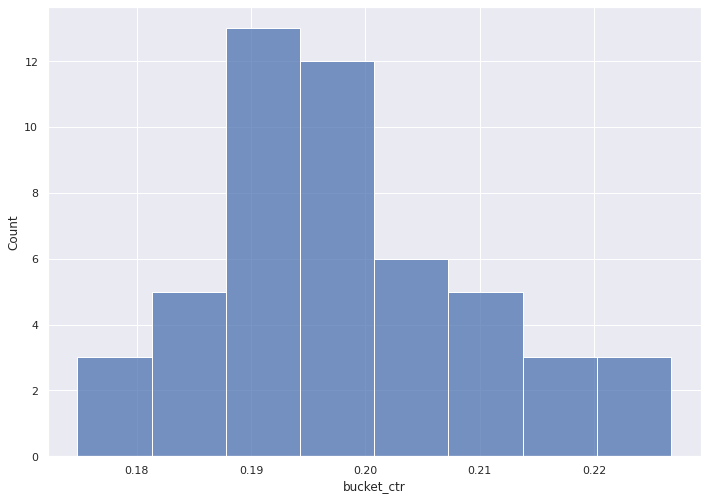

In [48]:
sns.histplot(df_bucket[df_bucket.exp_group==2].bucket_ctr)







Пуассоновский бутстрэп

<AxesSubplot:ylabel='Count'>

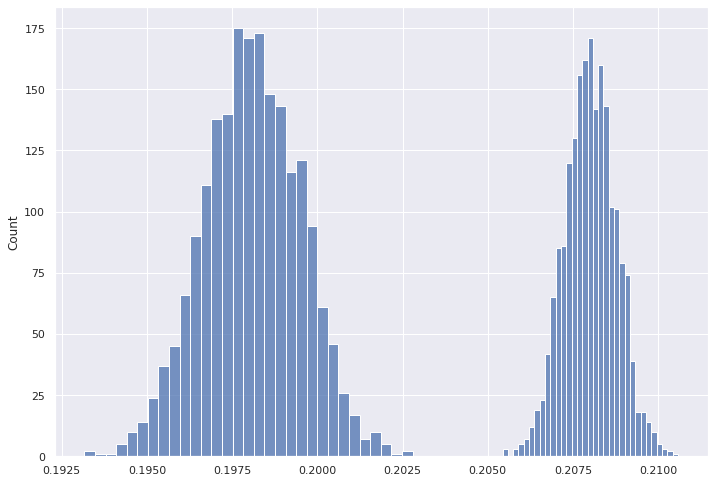

In [19]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = sp.stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = sp.stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2




likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

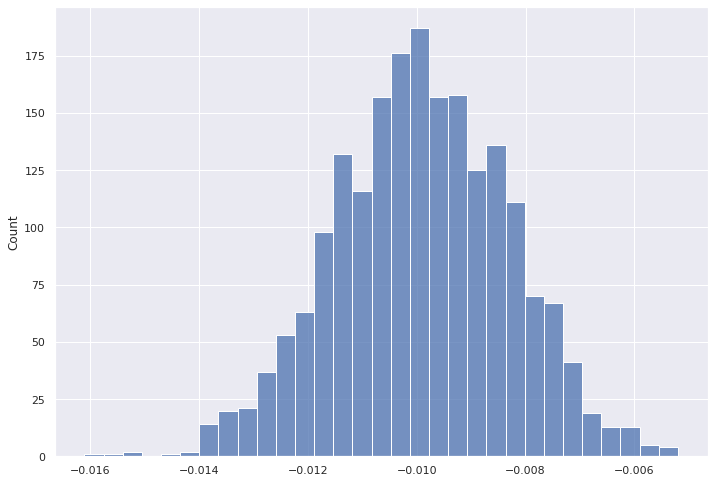

In [21]:
sns.histplot(ctr2-ctr1)